# Сборный проект №2

## Описание проекта

Стартап занимается приложением по продаже продуктов питания.

**Цель проекта** - разобраться в поведении пользователей мобильного приложения по продаже продуктов питания.

**Задачи**:
- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Дизайнеры решили сменить шрифты, менеджеры договорились принять решение на основе результатов A/A/B-теста. Пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, **какой шрифт лучше**.

**Описание данных**

В нашем распоряжении таблица с логами `/datasets/logs_exp.csv`. Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Ознакомление с данными

In [1]:
# импорт библиотек
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
import math as mth

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.max_colwidth', False)

In [2]:
# загрузка данных
df_logs = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t')  # логи

# присвоим имена датафрейму
df_logs.name = 'logs'

In [3]:
# выведем информацию о датафрейме df_logs

# 5 рандомных строк
print('-' * 5, 'Таблица', df_logs.name, '-' * 5)
display(df_logs.sample(5))
    
# общая информация
print('-' * 5, 'Общая информация о "', df_logs.name, '"', '-' * 5, '\n')
df_logs.info()
    
# пропуски
print('\n', '-' * 5, 'Пропуски в "', df_logs.name, '"', '-' * 5, '\n')
    
if df_logs.isna().sum().sum() != 0:
    display(df_logs.isna().sum().sort_values(ascending = False))
    print(f'Средний процент пропусков составил: {(df_logs.isna().sum()/len(df)*100).mean():.2f}%')
else:
    print('Пропусков не найдено \n')
        
# дубликаты
print('-' * 5, 'Информация о дубликатах в "', df_logs.name, '"', '-' * 5, '\n')
print('Количество явных дубликатов:', df_logs.duplicated().sum(), '\n')

----- Таблица logs -----


,EventName,DeviceIDHash,EventTimestamp,ExpId
22765,MainScreenAppear,7530416005686428986,1564668178,246
124160,OffersScreenAppear,5877487109553929606,1564922489,247
76799,MainScreenAppear,1232481244696430727,1564809919,246
87623,OffersScreenAppear,2201216441003038354,1564830934,246
21141,MainScreenAppear,3378438624605578285,1564665826,248


----- Общая информация о " logs " ----- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

 ----- Пропуски в " logs " ----- 

Пропусков не найдено 

----- Информация о дубликатах в " logs " ----- 

Количество явных дубликатов: 413 



**Вывод**
1. В таблице 244126 записей, отсутствуют пропуски;
2. Найдено 413 явных дубликатов. От них нужно будет избавиться;
3. Наименования столбцов не приведены к стилю snake_case;
4. Тип данных в столбце с датой некорректен (``int64`` вместо ``datetime``).

## Предобработка данных

Приведем наименования столбцов к единому стилю snack_case и изменим тип данных в столбцах с датой.

In [4]:
# переименуем столбцы
df_logs.rename(columns={'EventName': 'event_name',
                        'DeviceIDHash': 'device_id_hash',
                        'EventTimestamp': 'event_timestamp',
                        'ExpId': 'exp_id'}, inplace = True)

In [5]:
# преобразование дат
df_logs['event_timestamp'] = pd.to_datetime(df_logs['event_timestamp'], unit='s')

# добавим отдельный столбец с датой
df_logs['event_date'] = pd.to_datetime(df_logs['event_timestamp'], unit='d').dt.date

In [6]:
# дропнем дубликаты
df_logs = df_logs.drop_duplicates().reset_index(drop=True)
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


**Вывод**

Входные данные проанализированы. Пропусков нет. Данные с датой и временем приведены к соответствующему типу. Заголовки столбцов приведены к общепринятому формату, добавлен отдельный столбец с датой. Удалено 413 явных дубликатов.

Данные к анализу подготовлены.

## Изучение данных

Изучим и проверим данные подробнее.

In [7]:
print('Количество событий в логе:', len(df_logs))

Количество событий в логе: 243713


In [8]:
print('Количество пользователей в логе:', df_logs['device_id_hash'].nunique())

Количество пользователей в логе: 7551


In [9]:
print('Среднее количество событий на пользователя:', round(df_logs.groupby('device_id_hash')['event_name'].count().mean(), 0))

Среднее количество событий на пользователя: 32.0


In [10]:
df_logs.groupby('device_id_hash')['event_name'].count().describe()

count   7551.00
mean    32.28  
std     65.15  
min     1.00   
25%     9.00   
50%     20.00  
75%     37.00  
max     2307.00
Name: event_name, dtype: float64

Из описательной статистики видно, что медианное значение количества событий на пользователя (20) отличается от среднего (32). Максимальное количество событий на пользователя составляет 2307, а минимальное - 1. Слишкои большой размах. Возможно, что в данных есть аномалии. Выясним это чуть позже.

In [11]:
# максимальная и минимальная даты
print('Дата начала теста:', df_logs['event_date'].min())
print('Дата окончания теста:', df_logs['event_date'].max())

Дата начала теста: 2019-07-25
Дата окончания теста: 2019-08-07


Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп, для визуализации изменения количества данных.

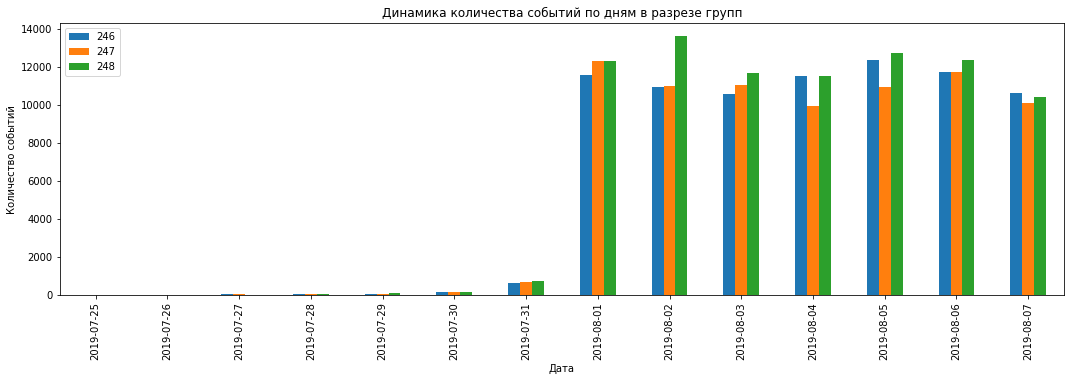

In [12]:
df_logs_pvt = df_logs.pivot_table(index='exp_id', 
                                  values='event_name',
                                  aggfunc='count', 
                                  columns='event_date').T

df_logs_pvt.plot(kind='bar', figsize=(18, 5));
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Динамика количества событий по дням в разрезе групп')
plt.legend(loc='upper left')
plt.show()

Утверждать, что у нас в наличии полные данные за весь период нельзя. По графику видно, что полноценные данные начинают появляться в конце июля 2019 г. То есть, в реальности мы располагаем данными с 1 августа 2019 г. Будем считать, что данные с 25 июля по 31 июля 2019 г. устарели.

In [13]:
# дропнем дефектные дни
df_logs_new = df_logs.query('event_date >= datetime(2019, 8, 1).date()')

Посчитаем, сколько событий и пользователей было очищено.

In [14]:
print(f'Потерянные события: {len(df_logs) - len(df_logs_new)} ({(len(df_logs) - len(df_logs_new)) / len(df_logs):.2f}%)')
print(f'Потерянные пользователи: {df_logs.device_id_hash.nunique() - df_logs_new.device_id_hash.nunique()} ({(df_logs.device_id_hash.nunique() - df_logs_new.device_id_hash.nunique()) / df_logs.device_id_hash.nunique():.2f}%)')

Потерянные события: 2826 (0.01%)
Потерянные пользователи: 17 (0.00%)


In [15]:
# удостоверимся, что в df_logs_new осталось 3 группы
df_logs_new['exp_id'].unique()

array([246, 247, 248])

После чистки данных мы потеряли 38967 событий, 265 пользователей, что составляет 0.16% и 0.04% от первоначальной выборки, соответственно. Все 3 группы пользователей сохранились.

In [16]:
df_logs_new.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

После фильтрации количество посетителей в группах осталось на приемлемом для анализа уровне. 

## Воронка событий

**Частота событий в логе**

In [17]:
df_logs_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear         46333 
CartScreenAppear           42303 
PaymentScreenSuccessful    33918 
Tutorial                   1005  
Name: event_name, dtype: int64

Наиболее часто встречаемое событие - `MainScreenAppear` (показ главной страницы), оно встречается 117328 раз. На втором месте по частоте находится событие `OffersScreenAppear` (46333), на третьем `CartScreenAppear` (42303). Видна некая воронка - переход от главной страницы к странице с успешной оплаты. `Tutorial` ранжируется на последнем месте, поэтому делаем вывод, что просмотр инструкции многие пользователи просто пропускают. Возможно, интерфейс приложения вполне интуитивно понятен для большинства пользователей.

Посчитаем, сколько пользователей совершили все события.

In [18]:
# построим пивот для определения кол-ва уникальных пользователей, совершивших события
df_logs_new_pvt = df_logs_new.pivot_table(index='event_name',
                                          values='device_id_hash',
                                          aggfunc='nunique').reset_index().sort_values(by='device_id_hash', 
                                                                                                ascending=False)

# переименуем столбец device_id_hash
df_logs_new_pvt.rename(columns={'device_id_hash': 'users_count'}, inplace = True)

# посчитаем долю пользователей по группе событий
df_logs_new_pvt['ratio'] = df_logs_new_pvt['users_count'] / df_logs_new['device_id_hash'].nunique()

# сбрасываем индексы, чтобы сохранить сортировку
df_logs_new_pvt = df_logs_new_pvt.reset_index(drop=True)
df_logs_new_pvt

,event_name,users_count,ratio
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


В полученной таблице `df_logs_new_pvt` по наименованиям событий можно **предположить**, что они образуют некую воронку: путь от главной страницы к странице с оплатой. <br>`Tutorial` - на то и есть туториал, его часто пропускают либо не пользуются им, если интерфейс приложения понятен пользователю.

**Доля проходящих пользователей на следующий шаг**

In [19]:
# поставим на первую позицию в group_ratio - 1
df_logs_new_pvt.loc[0, 'group_ratio'] = 1

# посчитаем долю пользователей в каждом следующем событии от "текущего"
for i in range(1, len(df_logs_new_pvt)):
    df_logs_new_pvt.loc[i, 'group_ratio'] = (df_logs_new_pvt.loc[i, 'users_count'] 
                                             / df_logs_new_pvt.loc[i - 1, 'users_count'])

df_logs_new_pvt

,event_name,users_count,ratio,group_ratio
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95
4,Tutorial,840,0.11,0.24


In [20]:
df_logs_new_pvt['group_ratio'] = df_logs_new_pvt['users_count'] / df_logs_new_pvt['users_count'].shift(1)

# поставим на первую позицию в group_ratio - 1
df_logs_new_pvt.loc[0, 'group_ratio'] = 1

# посмотрим, что получилось
df_logs_new_pvt

,event_name,users_count,ratio,group_ratio
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95
4,Tutorial,840,0.11,0.24


In [21]:
# уберем из воронки `Tutorial`
df_logs_new_pvt = df_logs_new_pvt.query('event_name != "Tutorial"')

In [22]:
# доля пользователей, дошедших до оплаты
print('Доля пользователей, увдевших страницу успешной оплаты:', round(((df_logs_new_pvt.query('event_name == "PaymentScreenSuccessful"').reset_index().loc[0, 'users_count'])
     / df_logs_new['device_id_hash'].nunique()) * 100, 2), '%')

Доля пользователей, увдевших страницу успешной оплаты: 46.97 %


Заметим, что **самый большой** скачок находится между появлением главной страницы `MainScreenAppear` и появлением `OffersScreenAppear`. То есть, 38% посетителей не проходят с главной на `MainScreenAppear`. Тем не менее, с этой страницы 81% пользователей переходят в корзину `CartScreenAppear` и затем 95% этих пользователей проводят оплату (переходят в `PaymentScreenSuccessful`).

Событие `Tutorial` можно исключить, так как оно не поможет нам в контексте нашей цели исследования.

Из всех пользователей около 47% увидели страницу успешной оплаты. 

## Результаты эксперимента

Проверим, есть ли пользователей, которые одновременно попали в несколько групп.

In [23]:
# new v1
print('Количество пользователей, попавших в несколько групп: ', len(df_logs_new.groupby('device_id_hash')['exp_id'].nunique().reset_index().query('exp_id > 1')))

Количество пользователей, попавших в несколько групп:  0


Изучим результаты эксперимента. Для начала выберем самое популярное событие.

In [24]:
# самое популярное событие
most_popular_event = df_logs_new.pivot_table(index='event_name',
                                             values='device_id_hash',
                                             aggfunc='nunique').sort_values(by='device_id_hash',
                                                                            ascending=False).reset_index().loc[0, "event_name"]

print(f'Самое популярное событие: {most_popular_event}')

Самое популярное событие: MainScreenAppear


Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп, посчитаем долю пользователей, совершивших это событие. См. условие: 246 и 247 — контрольные группы, 248 — экспериментальная.

In [25]:
# число пользователей, совершивших это событие в каждой из групп
users_pop_event = df_logs_new.query('event_name == @most_popular_event').pivot_table(index='event_name',
                                                                                     values='device_id_hash',
                                                                                     columns='exp_id',
                                                                                     aggfunc='nunique').reset_index()
# доля пользователей, совершивших это событие
users_pop_event['246_ratio'] = round(users_pop_event[246] / df_logs_new['device_id_hash'].nunique(), 2)
users_pop_event['247_ratio'] = round(users_pop_event[247] / df_logs_new['device_id_hash'].nunique(), 2)
users_pop_event['248_ratio'] = round(users_pop_event[248] / df_logs_new['device_id_hash'].nunique(), 2)

users_pop_event

exp_id,event_name,246,247,248,246_ratio,247_ratio,248_ratio
0,MainScreenAppear,2450,2476,2493,0.33,0.33,0.33


Проверим, будет ли отличие между группами статистически достоверным. Проверим гипотезы о равенстве **долей** групп 246 и 247, используя z-тест.

- **Гипотеза H0**: нет статистически значимого различия между долями групп
- **Гипотеза H1**: есть статистически значимое различие между долями групп

In [26]:
# Функция для получения p_value (взято из теории)
def get_p_value(users_success_1, 
                users_total_1, 
                users_success_2, 
                users_total_2, 
                group_name, 
                event_name,
                alpha):
    
    # alpha = 0.05  # критический уровень статистической значимости

    # доля успехов в первой группе:
    p1 = users_success_1 / users_total_1

    # пропорция успехов во второй группе:
    p2 = users_success_2 / users_total_2

    # пропорция успехов в комбинированном датасете:
    p_combined = (users_success_1 + users_success_2) / (users_total_1 + users_total_2)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / users_total_1 + 1 / users_total_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('-' * 10)
    print(f'Группа - {group_name}, событие - {event_name}:')
    print('  p-значение: ', p_value)
    
    if p_value < alpha:
        print('  Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
    return p_value

Применим функцию `get_p_value` для всех событий в `df_logs_new` и построим матрицу значений p_value для каждого уникального события в разрезе тестируемых групп.

In [27]:
# Исключим `Tutorial` - она не является частью воронки
df_logs_new = df_logs_new.query('event_name != "Tutorial"')

In [28]:
# пары групп
group_list = [[246, 247], [247, 248], [246, 248]]
list_events, list_event_p_value = [], []
cnt_hypotesis = 0

# возможно, это не совсем эффективный алгоритм, так как в двойном цикле идет обращение к df_logs_new через .query()
# для каждого уникального события
for event in df_logs_new['event_name'].unique():
    
    list_event_p_value = [event]
    
    # Для каждой пары групп из group_list
    for group in group_list:
        
        group_1 = group[0]
        group_2 = group[1]
        
        # кол-во успехов групп
        users_success_1 = df_logs_new.query('exp_id == @group_1 and event_name == @event')['device_id_hash'].nunique()
        users_success_2 = df_logs_new.query('exp_id == @group_2 and event_name == @event')['device_id_hash'].nunique()

        # Все пользователи групп (без деления на события)
        users_total_1 = df_logs_new.query('exp_id == @group_1')['device_id_hash'].nunique()
        users_total_2 = df_logs_new.query('exp_id == @group_2')['device_id_hash'].nunique()
        
        tested_group = str(group_1) + '_' + str(group_2)
        
        # считаем p-value по событиям в разрезе групп с alpha = 0.05
        p_value = get_p_value(users_success_1, 
                              users_total_1, 
                              users_success_2, 
                              users_total_2, 
                              tested_group, 
                              event,
                              0.05)
        
        list_event_p_value.extend([p_value])
        
        cnt_hypotesis += 1
    
    # добавляем p-value для очередной пары групп для текущего event
    list_events.append(list_event_p_value)
    
# создадим датафрейм по данным list_events
df_p_value = pd.DataFrame(list_events)

# переименуем столбцы (костыльно)
df_p_value.rename(columns={0: 'event_name',
                           1: '246_247',
                           2: '247_248',
                           3: '246_248'}, inplace = True)
print('')
print('--')
print(f'Проверено статистических гипотез: {cnt_hypotesis}')
df_p_value

----------
Группа - 246_247, событие - MainScreenAppear:
  p-значение:  0.7526703436483038
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - 247_248, событие - MainScreenAppear:
  p-значение:  0.5194964354051703
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - 246_248, событие - MainScreenAppear:
  p-значение:  0.3387114076159288
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - 246_247, событие - OffersScreenAppear:
  p-значение:  0.24786096925282264
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - 247_248, событие - OffersScreenAppear:
  p-значение:  0.9333751305879443
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - 246_248, событие - OffersScreenAppear:
  p-значение:  0.21442476639710506
  Не получилось отвергнуть нулевую гипотезу, н

,event_name,246_247,247_248,246_248
0,MainScreenAppear,0.75,0.52,0.34
1,OffersScreenAppear,0.25,0.93,0.21
2,CartScreenAppear,0.23,0.59,0.08
3,PaymentScreenSuccessful,0.11,0.73,0.22


При alpha = 0.05 статистически значимого различия между долями пар групп не наблюдается.

Сравним результаты экспериментальной группы (248) с объединенной контрольной группой (246+247), чтобы понять повлияло ли изменение шрифта на поведение пользователей по всем событиям. Гипотезы те же:

- **Гипотеза H0**: нет статистически значимого различия между долями групп
- **Гипотеза H1**: есть статистически значимое различие между долями групп

In [29]:
list_events, list_event_p_value = [], []

for event in df_logs_new['event_name'].unique():
    
    list_event_p_value = [event]
    
    # кол-во успехов групп
    users_success_1 = df_logs_new.query('exp_id != 248 and event_name == @event')['device_id_hash'].nunique()
    users_success_2 = df_logs_new.query('exp_id == 248 and event_name == @event')['device_id_hash'].nunique()

    # Все пользователи групп (без деления на события)
    users_total_1 = df_logs_new.query('exp_id != 248')['device_id_hash'].nunique()
    users_total_2 = df_logs_new.query('exp_id == 248')['device_id_hash'].nunique()

    tested_group = 'Контрольная/248'

    # считаем p-value по событиям в разрезе групп
    p_value = get_p_value(users_success_1, 
                          users_total_1, 
                          users_success_2, 
                          users_total_2, 
                          tested_group, 
                          event,
                          0.05)
    
    list_event_p_value.extend([p_value])
    list_events.append(list_event_p_value)
    
    cnt_hypotesis += 1
    
# создадим датафрейм по данным list_events
df_p_value_2 = pd.DataFrame(list_events)

# переименуем столбцы (костыльно)
df_p_value_2.rename(columns={0: 'event_name',
                             1: '246_247/248'}, inplace = True)

print('')
print('--')
print(f'Проверено статистических гипотез: {cnt_hypotesis}')
df_p_value_2

----------
Группа - Контрольная/248, событие - MainScreenAppear:
  p-значение:  0.3486684291093256
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - OffersScreenAppear:
  p-значение:  0.44582745409482394
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - CartScreenAppear:
  p-значение:  0.18683558686831558
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - PaymentScreenSuccessful:
  p-значение:  0.6107918742187335
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

--
Проверено статистических гипотез: 16


,event_name,246_247/248
0,MainScreenAppear,0.35
1,OffersScreenAppear,0.45
2,CartScreenAppear,0.19
3,PaymentScreenSuccessful,0.61


Статистически значимого различия между группами нет - нулевая гипотеза не отвергнута по всем событиям при alpha = 0.05. Минимальное p-value составляет 0.18 по событию `CartScreenAppear`, а максимальное - 0.61 по `PaymentScreenSuccessful`.

В нашем распоряжении было 4 пары исследуемых групп (246/247, 247/248, 246/248, 246_247/248) и 4 событий, соответственно, было проведено 16 проверок статистических гипотез.

In [30]:
bonferroni_alpha = 0.05 / 16  # произведено 16 сравнений

list_events, list_event_p_value = [], []

for event in df_logs_new['event_name'].unique():
    
    list_event_p_value = [event]
    
    # кол-во успехов групп
    users_success_1 = df_logs_new.query('exp_id != 248 and event_name == @event')['device_id_hash'].nunique()
    users_success_2 = df_logs_new.query('exp_id == 248 and event_name == @event')['device_id_hash'].nunique()

    # Все пользователи групп (без деления на события)
    users_total_1 = df_logs_new.query('exp_id != 248')['device_id_hash'].nunique()
    users_total_2 = df_logs_new.query('exp_id == 248')['device_id_hash'].nunique()

    tested_group = 'Контрольная/248'

    # считаем p-value по событиям в разрезе групп
    p_value = get_p_value(users_success_1, 
                          users_total_1, 
                          users_success_2, 
                          users_total_2, 
                          tested_group, 
                          event,
                          bonferroni_alpha)
    
    list_event_p_value.extend([p_value])
    list_events.append(list_event_p_value)
    
    cnt_hypotesis += 1
    
# создадим датафрейм по данным list_events
df_p_value_3 = pd.DataFrame(list_events)

# переименуем столбцы (костыльно)
df_p_value_3.rename(columns={0: 'event_name',
                             1: '246_247/248'}, inplace = True)

df_p_value_3

----------
Группа - Контрольная/248, событие - MainScreenAppear:
  p-значение:  0.3486684291093256
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - OffersScreenAppear:
  p-значение:  0.44582745409482394
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - CartScreenAppear:
  p-значение:  0.18683558686831558
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
----------
Группа - Контрольная/248, событие - PaymentScreenSuccessful:
  p-значение:  0.6107918742187335
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


,event_name,246_247/248
0,MainScreenAppear,0.35
1,OffersScreenAppear,0.45
2,CartScreenAppear,0.19
3,PaymentScreenSuccessful,0.61


Результаты не изменились, поэтому значение alpha = 0.05 выбрано оптимально.

**Вывод**

1. Самое популярное событие: `MainScreenAppear`,
2. Статистически значимого различия между долями в контрольных группах нет,
3. Статистически значимого различия по долям в экспериментальной и контрольной группах нет.
4. Уровень статистической значимости (alpha) выбран 0.05.

Разбиение на группы работает корректно. Результат A/B-теста - изменение шрифта не повлияло на поведение пользователей.

## Вывод

Нам был предоставлен датафрейм без пропусков. На этапе предобработки привели данные с датой и временем события к корректному типу, заголовки столбцов к общепринятому формату, удалили 413 явных дубликатов.

**Проверка данных**

Было принято решение анализировать интервал с 1 августа по 7 августа 2019 г. - в этом промежутке содержатся полноценные данные. До 31 июля количество событий в группах оказалось крайне мало. Потери в данных незначительные (события - 0.16%, пользователи - 0.04%).

**Воронка событий**

Было выделено 4 основных события, составляющих воронку: `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, `PaymentScreenSuccessful`. Исключили событие `Tutorial`, так как оно не несет смысловой нагрузки для достижения цели Проекта.

- На шаге с `MainScreenAppear` на `OffersScreenAppear` теряется больше всего пользователей - 38%,
- 47% пользователей увидели страницу успешной оплаты.

**Результаты эксперимента**

- Наиболее популярное событие - `MainScreenAppear`,
- Между долями контрольных групп статистически значимого различия не наблюдается (при alpha = 0.05). Разбиение на группы работает корректно,
- Статистически значимого различия между долями контрольной и экспериментальной группами не наблюдается (при alpha = 0.05, с учетом поправки Бонферрони). 

Таким образом, при прочих равных условиях **изменение шрифтов не повлияло на поведение пользователей**.